<a href="https://colab.research.google.com/github/javierballesteros1/GNN-solubility-of-a-molecule-with-Zinc/blob/main/PyG_How_to_Evaluate_the_Solubility_of_a_Molecule_with_Zinc_through_Graph_Neural_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PyG: How to Evaluate the Solubility of a Molecule with Zinc through Graph Neural Networks

# 0. Import packages

In [1]:
import torch

#If you are in collab install this
!pip uninstall torch-scatter torch-sparse torch-geometric torch-cluster  --y
!pip install torch-scatter -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install torch-cluster -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install git+https://github.com/pyg-team/pytorch_geometric.git

from torch_geometric.datasets import  ZINC
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv, global_mean_pool
import torch.nn as nn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-1.13.0+cu116.html
     |████████████████████████████████| 9.4 MB 7.2 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-1.13.0+cu116.html
     |████████████████████████████████| 4.6 MB 7.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-1.13.0+cu116.html
     |████████████████████████████████| 3.2 MB 6.5 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/pyg-team/pytorch_geometric.git to /tmp/pip-req-build-c0rsetec
  Running command git clone -q https://github.com/pyg-team/pytorch_geometric.git /tmp/pip-req-build-c0rsetec
     |██████████████████████████

# 1. Import the Zinc data set

In [2]:
root = 'data/ZINC'

# We upload train, validation and test sets
train_dataset = ZINC(root, subset=False, split='train') 
val_dataset = ZINC(root, subset=False, split='val')
test_dataset = ZINC(root, subset=False, split='test')

Extracting data/ZINC/molecules.zip
Processing...
Processing test dataset: 100%|██████████| 5000/5000 [00:00<00:00, 10518.68it/s]
Done!


# 2. Describe the Zinc dataset

First, let's see a quick description of the whole data set. For this purpose we have been inspired by the [Google Colab](https://pytorch-geometric.readthedocs.io/en/latest/notes/colabs.html) provided by the PyG documentation (1. Introduction)

In [3]:
dataset = ZINC(root = root)

print()
print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')


Dataset: ZINC(220011):
Number of graphs: 220011
Number of features: 1
Number of classes: 218362


Now, let's see basic description of each molecule (graph):

In [4]:
data = dataset[0]  

print()
print(data)
print('=============================================================')

# Gather some statistics about the first graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Is undirected: {data.is_undirected()}')


Data(x=[33, 1], edge_index=[2, 72], edge_attr=[72], y=[1])
Number of nodes: 33
Number of edges: 72
Average node degree: 2.18
Has isolated nodes: False
Is undirected: True


## 2.1. Let's see a molecule

In [5]:
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx

Below we are going to show the graph of a molecule, where we can observe the nodes (atoms) and how they are connected through edges. In the example below we see 33 atoms and 36 connections between them.

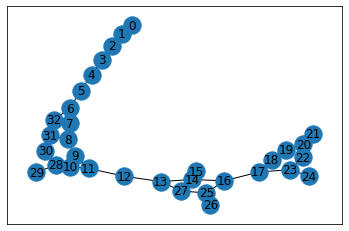

In [6]:
G = to_networkx(data, to_undirected=True)
nx.draw_networkx(G)
plt.show()

# 3. Batching of graphs

Following the instructions of the documentation of PyG in [Google Colab 3. Graph Classification with Graph Neural Networks](https://pytorch-geometric.readthedocs.io/en/latest/notes/colabs.html), we are going to batch the graphs before inputting them into a Graph Neural Network to guarantee full GPU utilization. The length of this dimension is then equal to the number of examples grouped in a mini-batch and is typically referred to as the `batch_size`.

In [7]:
batch_size = 2**8

train_dataloader = DataLoader(dataset=train_dataset, batch_size=batch_size, num_workers=2)
val_dataloader = DataLoader(dataset=val_dataset, batch_size=batch_size, num_workers=2)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=batch_size, num_workers=2)

Below we are going to display the number of batches and the number of graphs within each batch

In [ ]:
for step, data in enumerate(train_dataloader):
    print(f'Step {step + 1}:')
    print('=======')
    print(f'Number of graphs in the current batch: {data.num_graphs}')
    print(data)
    print()

Step 1:
Number of graphs in the current batch: 1024
DataBatch(x=[23810, 1], edge_index=[2, 51236], edge_attr=[51236], y=[1024], batch=[23810], ptr=[1025])

Step 2:
Number of graphs in the current batch: 1024
DataBatch(x=[23831, 1], edge_index=[2, 51286], edge_attr=[51286], y=[1024], batch=[23831], ptr=[1025])

Step 3:
Number of graphs in the current batch: 1024
DataBatch(x=[23754, 1], edge_index=[2, 51104], edge_attr=[51104], y=[1024], batch=[23754], ptr=[1025])

Step 4:
Number of graphs in the current batch: 1024
DataBatch(x=[23791, 1], edge_index=[2, 51152], edge_attr=[51152], y=[1024], batch=[23791], ptr=[1025])

Step 5:
Number of graphs in the current batch: 1024
DataBatch(x=[23757, 1], edge_index=[2, 51166], edge_attr=[51166], y=[1024], batch=[23757], ptr=[1025])

Step 6:
Number of graphs in the current batch: 1024
DataBatch(x=[23579, 1], edge_index=[2, 50688], edge_attr=[50688], y=[1024], batch=[23579], ptr=[1025])

Step 7:
Number of graphs in the current batch: 1024
DataBatch(x=

# 4. Graph Neural Network Architecture



## 4.1. Define the NN

As we can see in the README.MD, the GNN is based on two type of layers:

*   Message passing layers: with the goal of node embedding, nodes update their representations by aggregating the messages received from their immediate neighbours.
*   Readout layer: collects all node representations in a graph to form a graph representation



In [8]:
class GCN(nn.Module):
    def __init__(self, num_features, num_classes, hidden_channels_1, hidden_channels_2):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_features, hidden_channels_1)
        self.conv2 = GCNConv(hidden_channels_1, hidden_channels_1)
        self.conv3 = GCNConv(hidden_channels_1, hidden_channels_2)
        self.conv4 = GCNConv(hidden_channels_2, num_classes)

    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings through Message passing layers 
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = self.conv2(x, edge_index)
        x = torch.relu(x)
        x = self.conv3(x, edge_index)
        x = torch.relu(x)
        x = self.conv4(x, edge_index)

        # 2. Readout layer
        g_pool = global_mean_pool(x, batch)
        return g_pool

After many trials, we reached that `hidden_channels_1 = 4, hidden_channels_2 = 4` are the best parameters for this model, as we explain the README.DM


In [11]:
model = GCN(num_features = 1, num_classes = 1, hidden_channels_1 = 4, hidden_channels_2 = 4)  # num_classes should be 1 for regression tasks
model

GCN(
  (conv1): GCNConv(1, 4)
  (conv2): GCNConv(4, 4)
  (conv3): GCNConv(4, 4)
  (conv4): GCNConv(4, 1)
)

## 4.2. A first forward example of the GNN

Let's see a first example without training the GNN. That is, a forward pass without doing backward propagation. For this purpose, first we are going to select a batch in the training set, and we will predict the solubility for each molecule in this batch:



In [9]:
for d in train_dataloader:
    example_data = d
    break
print(example_data)

DataBatch(x=[5938, 1], edge_index=[2, 12784], edge_attr=[12784], y=[256], batch=[5938], ptr=[257])


We see above the size of each batch. The size of `y` is 256, so we are going to predict the solubility of 256 molecules:

In [12]:
example_prediction = model(example_data.x.to(torch.float32), example_data.edge_index, example_data.batch)
print(example_prediction.size())

torch.Size([256, 1])


## 4.3. Train the GNN

Ahora vamos a entrenar la GNC

In [13]:
# Import required
import matplotlib.pyplot as plt
from statistics import mean

In [14]:
total_train_loss = [] # here we are going to store the mean of the training loss of all the batches for each epoch
total_val_loss = [] # here we are going to store the mean of the validation loss of all the batches for each epoch
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)
num_epochs = 20 

model.train()

for epoch in range(num_epochs):
    train_running_loss = []
    val_running_loss = []
    
    # Loop over the training dataset
    for data in train_dataloader:
        # Forward pass
        output = model(data.x.to(torch.float32), data.edge_index, data.batch)
        loss = loss_fn(output.squeeze(), data.y)

        # Backward pass
        optimizer.zero_grad()         # reset the optimizer gradient'
        loss.backward()               # Backward the loss
        optimizer.step()              # Apply optimizer

        # Track the running loss for the training set
        train_running_loss.append(loss.item())

    total_train_loss.append(mean(train_running_loss))

    # Loop over the validation dataset
    with torch.no_grad():
        for data in val_dataloader:
            # Forward pass
            output = model(data.x.to(torch.float32), data.edge_index, data.batch)
            loss = loss_fn(output.squeeze(), data.y)

            # Track the running loss for the validation set
            val_running_loss.append(loss.item())

    total_val_loss.append(mean(val_running_loss))
    
    # Print the loss for the current epoch
    print(f"Epoch {epoch+1}/{num_epochs}: Training Loss = {total_train_loss[-1]} Validation Loss = {total_val_loss[-1]}")

Epoch 1/20: Training Loss = 4.264682565733444 Validation Loss = 4.256985858082771
Epoch 2/20: Training Loss = 4.196534926669542 Validation Loss = 4.253626830875874
Epoch 3/20: Training Loss = 4.195634904018668 Validation Loss = 4.253463978568713
Epoch 4/20: Training Loss = 4.195291304033856 Validation Loss = 4.25287102162838
Epoch 5/20: Training Loss = 4.193476179311442 Validation Loss = 4.247893465061982
Epoch 6/20: Training Loss = 4.1796433393345325 Validation Loss = 4.220531823734443
Epoch 7/20: Training Loss = 4.12991163952406 Validation Loss = 4.1379833072423935
Epoch 8/20: Training Loss = 4.026336758635765 Validation Loss = 4.0137569804986315
Epoch 9/20: Training Loss = 3.9054655601811965 Validation Loss = 3.8908849904934564
Epoch 10/20: Training Loss = 3.7937225508135417 Validation Loss = 3.7824560329318047
Epoch 11/20: Training Loss = 3.6971327207809273 Validation Loss = 3.68999503304561
Epoch 12/20: Training Loss = 3.6152572246484977 Validation Loss = 3.611915116508802
Epoch 1

Find below the plot of the evolution of the loss for each epoch for both the training and validation sets:

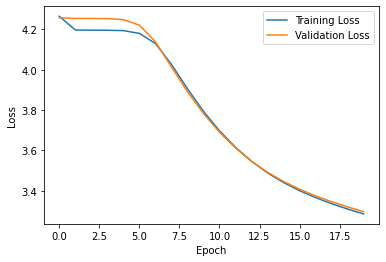

In [15]:
# Plot the running loss
plt.plot(total_train_loss, label="Training Loss")
plt.plot(total_val_loss, label="Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## 4.4. Test

Finally, we are going to run the GNN model trained above on the test data set

In [16]:
total_test_loss = []
test_running_loss = []
for data in test_dataloader:
    # Forward pass
    output = model(data.x.to(torch.float32), data.edge_index, data.batch)
    loss  = loss_fn(output.squeeze(), data.y)

    # Track the running loss for the validation set
    test_running_loss.append(loss.item())

total_test_loss.append(mean(test_running_loss))


In [ ]:
total_test_loss

[2.9310264945030213]

In [ ]:
test_running_loss

[2.531412124633789,
 2.4415268898010254,
 3.323113441467285,
 2.265665054321289,
 2.624110460281372,
 2.84913969039917,
 3.587135076522827,
 2.668394088745117,
 2.227173328399658,
 3.666693687438965,
 2.3596150875091553,
 3.068843126296997,
 3.4332127571105957,
 2.969585418701172,
 2.595447301864624,
 3.5132100582122803,
 3.8870036602020264,
 2.9172720909118652,
 3.015608787536621,
 2.67636775970459]

# References


[1]: [Graph Neural Network and Some of GNN Applications: Everything You Need to Know](https://neptune.ai/blog/graph-neural-network-and-some-of-gnn-applications#:~:text=Graph%20Neural%20Networks%20(GNNs)%20are,and%20graph%2Dlevel%20prediction%20tasks). 

[2]: [TORCH_GEOMETRIC.DATASETS](https://pytorch-geometric.readthedocs.io/en/latest/modules/datasets.html#torch_geometric.datasets.ZINC). 

[3]: [PYG: COLAB NOTEBOOKS AND VIDEO TUTORIALS](https://pytorch-geometric.readthedocs.io/en/latest/notes/colabs.html)

[4]: [Graph neural network](https://en.wikipedia.org/wiki/Graph_neural_network)

[5]: [Node embeddings for Beginners](https://towardsdatascience.com/node-embeddings-for-beginners-554ab1625d98#:~:text=Node%20embeddings%20are%20a%20way,in%20machine%20learning%20prediction%20tasks.)

[6]: [Graph Neural Network Layers](https://torchdrug.ai/docs/notes/layer.html#:~:text=A%20readout%20layer%20collects%20all,every%20node%20in%20the%20graph.)

[7]: [A Beginner’s Guide to Graph Neural Networks Using PyTorch Geometric — Part 1](https://towardsdatascience.com/a-beginners-guide-to-graph-neural-networks-using-pytorch-geometric-part-1-d98dc93e7742)